---
title: "Waiting time analysis"
---

[Archived notebook using Python and R](analysis/01_occurence_rate.ipynb)

## Notes

- Occurence rate is related to the waiting time distribution.

It is hard to remove duplicate events when combining multiple datasets with different τ. So when using the combined dataset, the occurence rate would be overestimated.


> An analysiswas carried out to determine the probability distribution governing the time interval between successive discontinuities. The times at which the discontinuities occurred,obtainedfromthe identificationprogram, were used to computethe time difference, $τ = T_j - T_{j-1}$, the so-called interarrival interval. The number of cases were then tabulated corresponding to discreteranges of τ, and a histogramwas prepared.By properly normalizing the numberof casesin each range a probability distribution function giving the relative frequency of occurrencewas obtained. A similar study was previously carried out by Burlaga[1969].



In [3]:
using DrWatson
@quickactivate
include(srcdir("main.jl"))

using CairoMakie

In [4]:
# j_events_taus = load_taus(60:-10:20);
wind_df = load(datadir("updated_events_Wind_tr=20110825-20160630_method=fit_tau=0:01:00_ts=0:00:00.090909.arrow"));
jno_df = load(datadir("updated_events_JNO_method=fit_tau=0:01:00_ts=0:00:01.arrow"));

┌ Warning: automatically converting Arrow.Timestamp with precision = MICROSECOND to `DateTime` which only supports millisecond precision; conversion may be lossy; to avoid converting, pass `Arrow.Table(source; convert=false)
└ @ Arrow /Users/zijin/.julia/packages/Arrow/5pHqZ/src/eltypes.jl:273
┌ Warning: automatically converting Arrow.Timestamp with precision = NANOSECOND to `DateTime` which only supports millisecond precision; conversion may be lossy; to avoid converting, pass `Arrow.Table(source; convert=false)
└ @ Arrow /Users/zijin/.julia/packages/Arrow/5pHqZ/src/eltypes.jl:273


In [5]:
df = wind_df;
df_s1 = subset(df, :time => t -> year.(t) .== 2013);
df_s2 = subset(df_s1, :time => t -> month.(t) .< 2);

In [6]:
function waiting_time(df; col=:time, δt = Dates.Minute(1))
    time = df[:, col]
    # unique and order the time
    time = time |> unique |> sort
    τ = diff(time)
    return τ ./ δt
end

waiting_time (generic function with 1 method)

In [7]:
using FHist
using Distributions


"""
Plot the waiting time distribution of the data
"""
function plot_wt_pdf(τ; step = 5, xscale = identity)
    binedges = 0:step:maximum(τ)

    h = Hist1D(τ; binedges=binedges)
    h = normalize(h)
    d = fit(Exponential, τ)

    x = bincenters(h)
    y = pdf(d, x)

    f = Figure()
    ax = Axis(f[1, 1], yscale=log10, xscale=xscale, xlabel="τ (minutes)", ylabel="p(τ)")
    errorbars!(ax, h; color=:black, whiskerwidth=6)
    # plot the fit
    lines!(ax, x, y, color = :red, linewidth = 2)
    
    xlims!(ax, 1, 100)
    ylims!(ax, 5e-4, 8e-2)
    f
end

plot_wt_pdf

In [8]:
subset_jno(df, r) = subset(df, :radial_distance => x -> round_c.(x) .== r)
subset_time(df, t) = subset(df, :time => x -> x .< t)

subset_time (generic function with 1 method)

In [9]:
jno_df_ss1 = subset(jno_df, :radial_distance => x -> x .< 1.1)
jno_df_s1 = subset_jno(jno_df, 1);
jno_df_s2 = subset_jno(jno_df, 5);

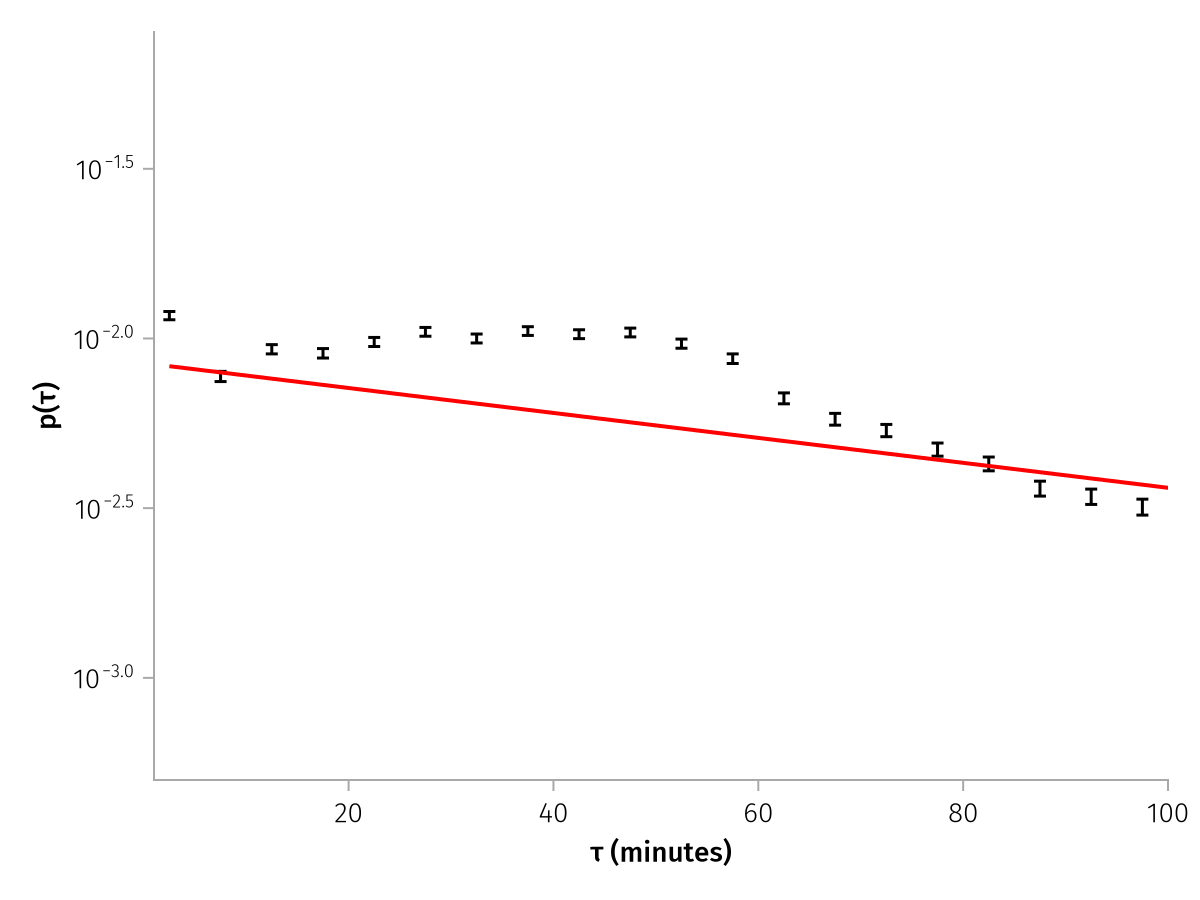

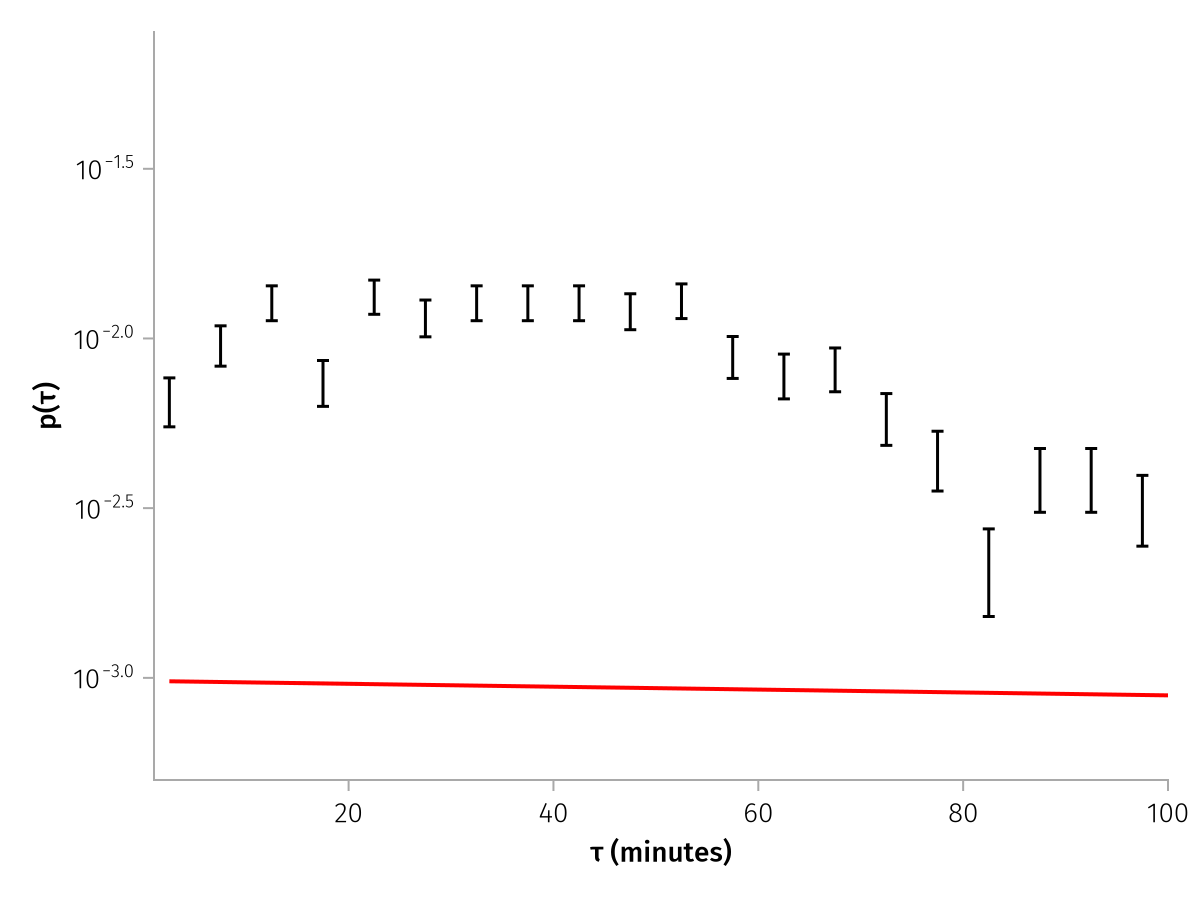

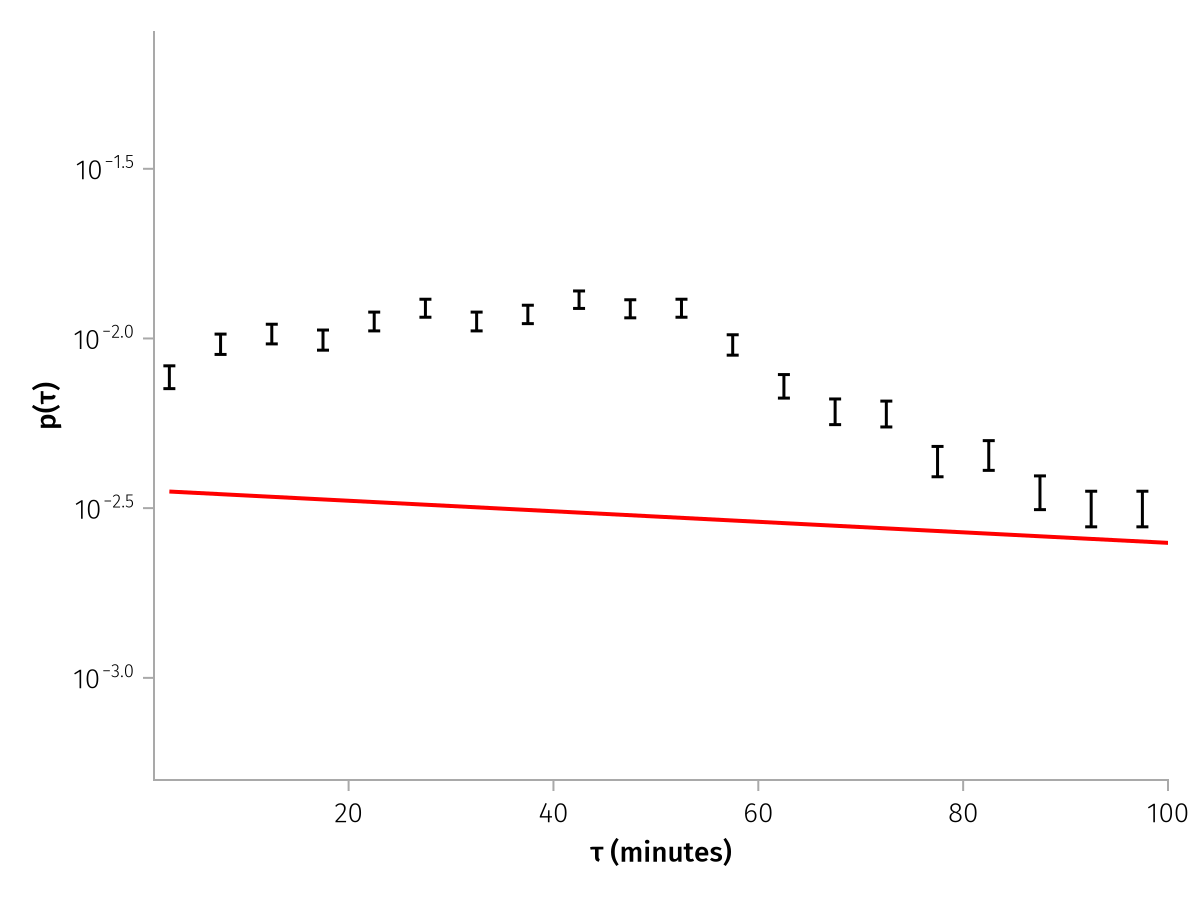

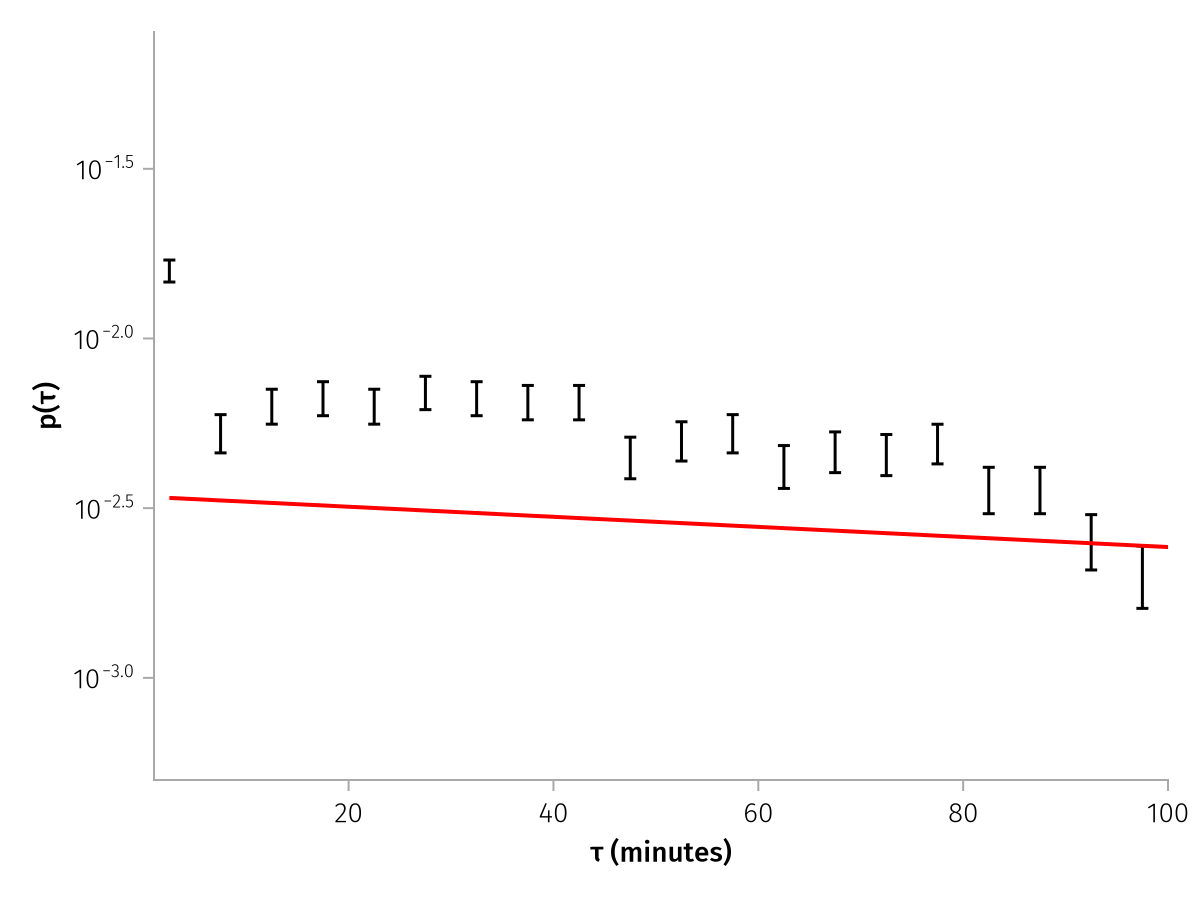

In [10]:
dfs = [ jno_df, jno_df_ss1, jno_df_s1, jno_df_s2 ]
fgs = dfs .|> waiting_time .|> plot_wt_pdf 
display.(fgs);

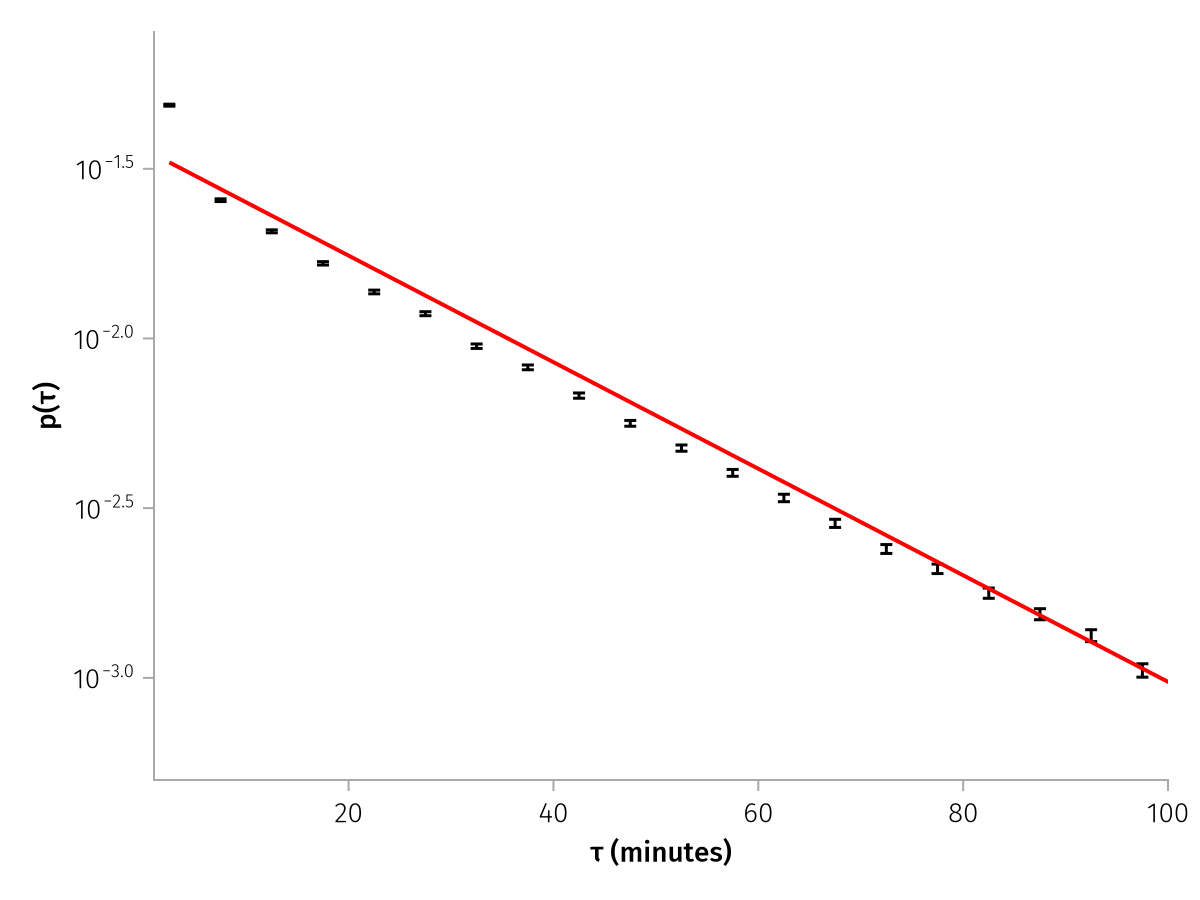

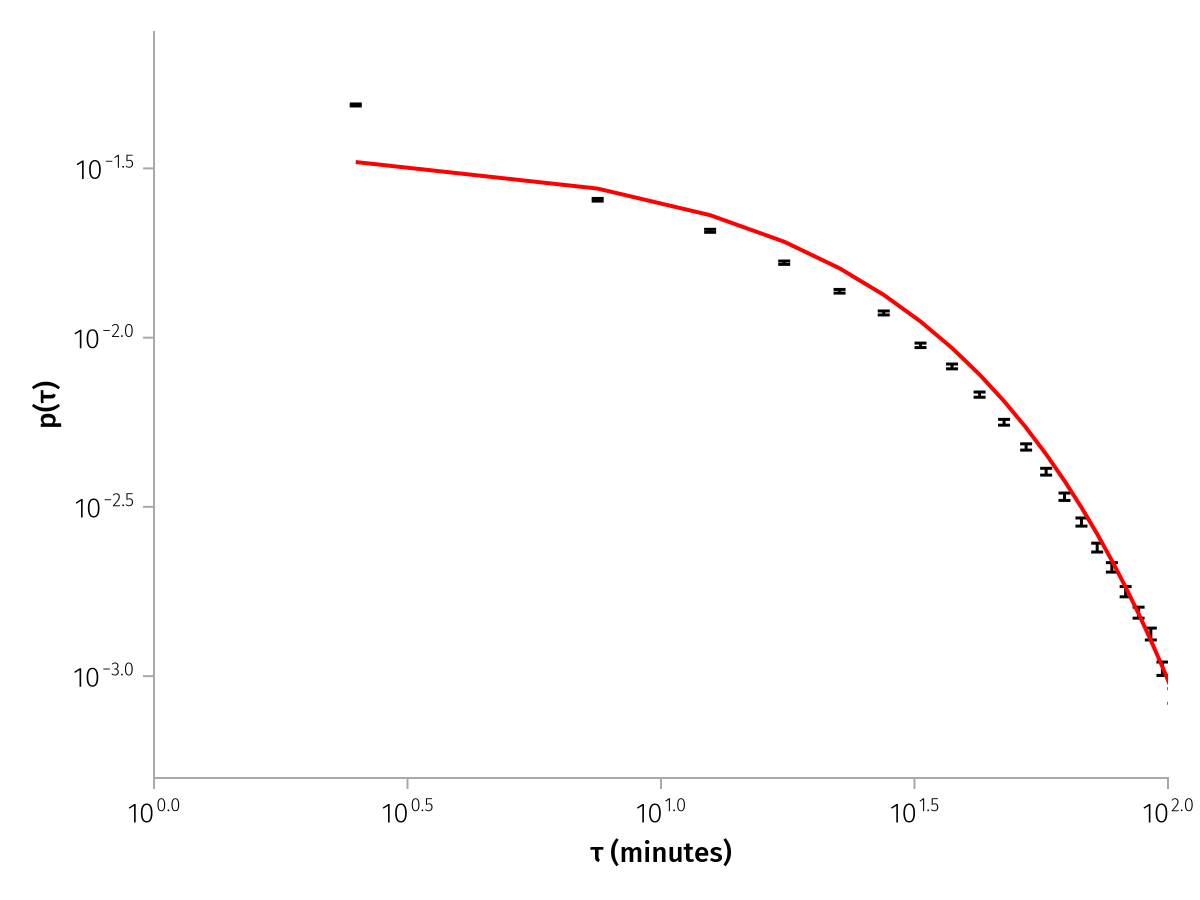

In [11]:
f1 = plot_wt_pdf(df |> waiting_time)
f2 = plot_wt_pdf(df |> waiting_time, xscale = log10)
display.([f1, f2]);

In [1]:
f1 = plot_wt_pdf(df_s2 |> waiting_time)
f2 = plot_wt_pdf(df_s2 |> waiting_time, xscale = log10)
display.([f1, f2]);

UndefVarError: UndefVarError: `df_s2` not defined

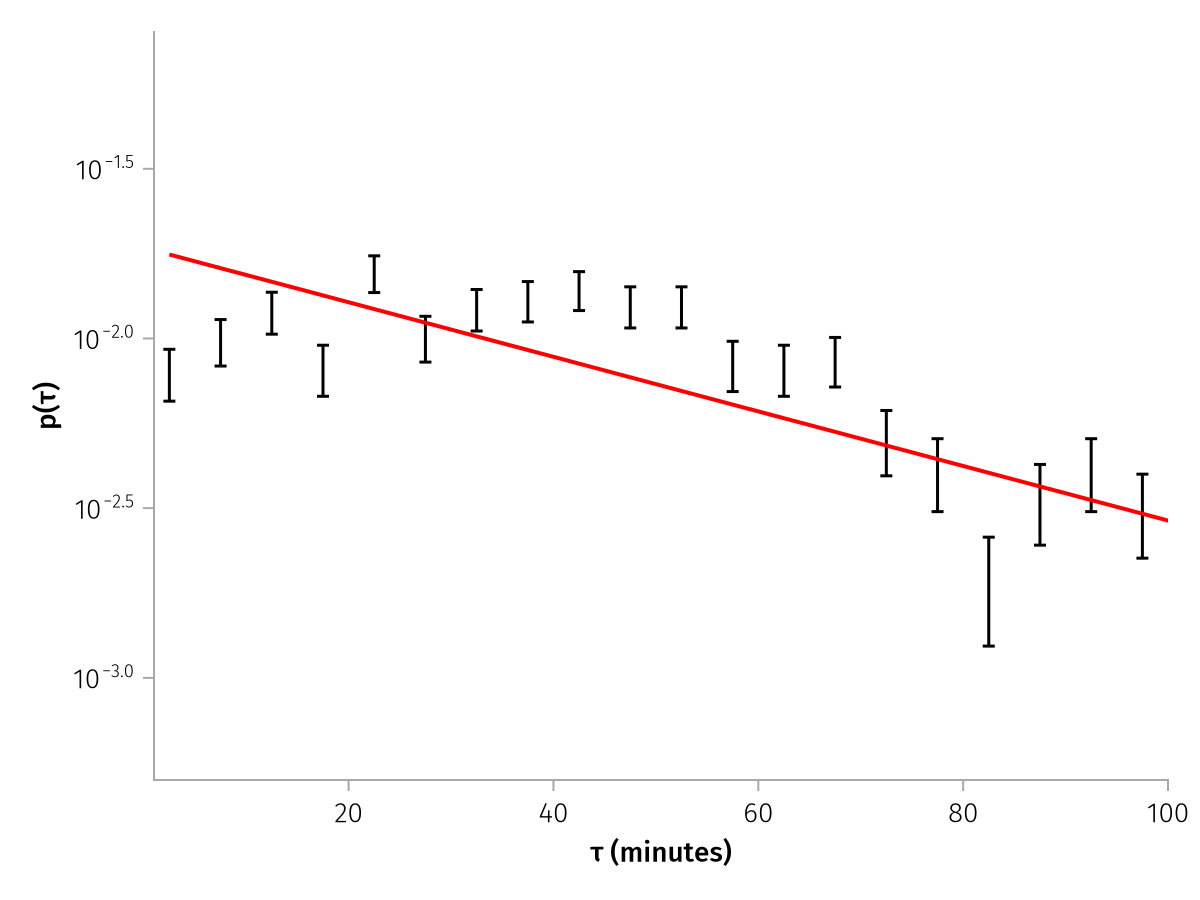

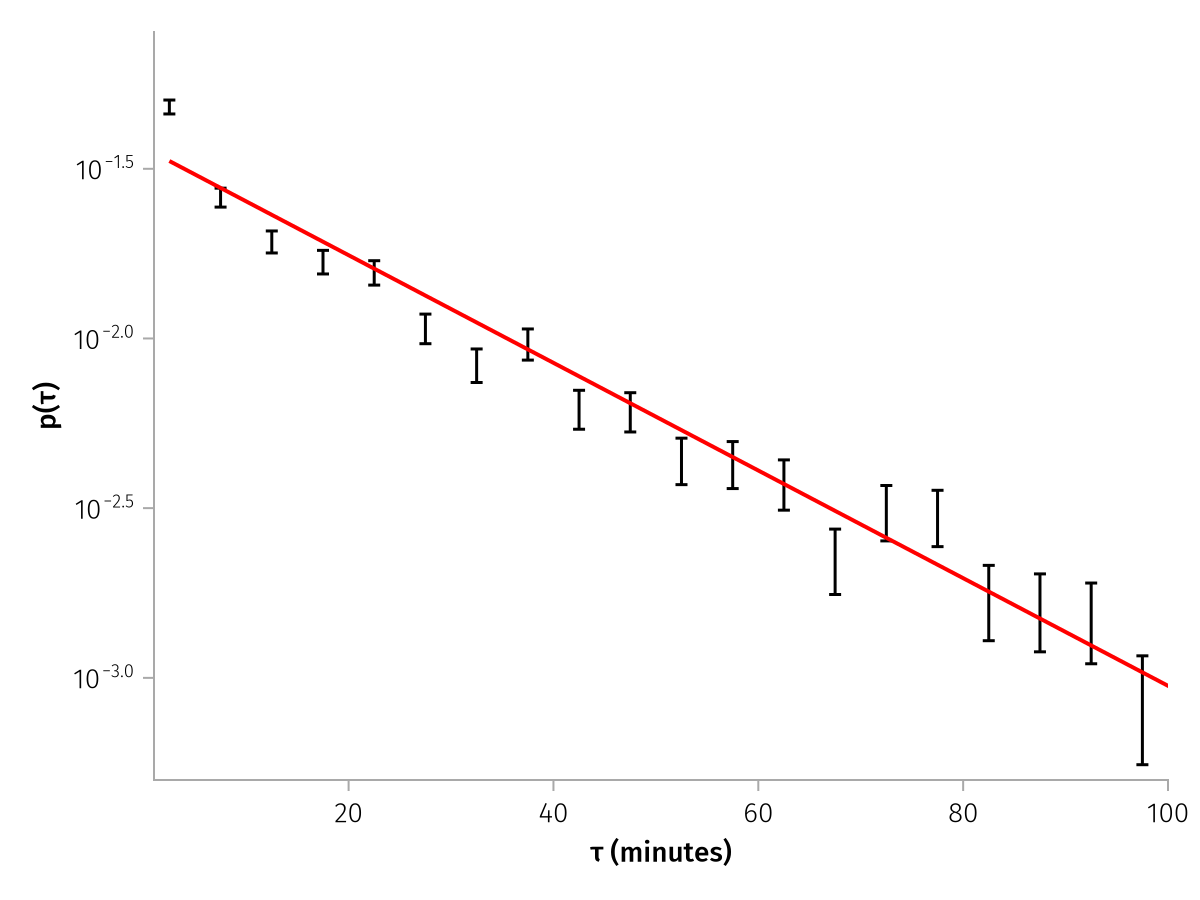

In [52]:
df1 = subset_time(jno_df, Date(2011, 9, 30))
df2 = subset_time(wind_df, Date(2011, 9, 30))
dfs = [ df1, df2 ]
fgs = dfs .|> waiting_time .|> plot_wt_pdf 
display.(fgs);